In [1]:
# ===== 模块导入 =====
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from scipy.stats import ttest_ind
from deap import base, creator, tools, algorithms
import random
import warnings
from draw import *

In [2]:

# ===== 设置输出格式和告警 =====
warnings.filterwarnings("ignore")

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# ===== 读取数据 =====
df = pd.read_csv(r'C:\Users\WENVM\Desktop\hypertension_data.csv')
df.shape

(84569, 26)

In [4]:
# 处理数据，将原始英文列名转化成中文
reverse_dict =  {
    'age': '年龄',
    'height': '身高',
    'weight': '平均体重',
    'bmi': 'BMI',
    'pregnancy_method': '妊娠方式',
    'family_history': '家族史',
    'pre_gestational_diabetes': '孕前糖尿病',
    'pre_gestational_hypertension': '孕前高血压',
    'urea': '尿素',
    'cystatin_C': '胱抑素C',
    'total_cholesterol': '总胆固醇',
    'pregnancy_count': '怀孕次数',
    'abortion_count': '流产次数',
    'delivery_count': '生产次数',
    'triglycerides': '甘油三酯',
    'papp_a_mom': '血浆蛋白-A',
    'serum_PLG': '血清PLG',
    'uric_acid': '尿酸',
    'prenatal_visits': '产检次数',
    'smoking': '抽烟',
    'alcohol_use': '饮酒',
    'pre_pc_ovarian_syndrome': '孕前卵巢多囊综合征',
    'pre_nephritis': '孕前肾炎',
    'pre_proteinuria': '孕前蛋白尿',
    'creatinine': '肌酐',
    'gh_labels': '妊娠期高血压',
}
df.rename(columns=reverse_dict, inplace=True)
df

,年龄,身高,BMI,平均体重,妊娠方式,家族史,孕前糖尿病,孕前高血压,尿素,胱抑素C,...,血清PLG,尿酸,产检次数,抽烟,饮酒,孕前卵巢多囊综合征,孕前肾炎,孕前蛋白尿,肌酐,妊娠期高血压
0,30,156.8,29.7,72.1,0,0,0,0,3.82,0.88,...,203.948710,260.014235,16,0,0,0,0,0,70.396708,0
1,31,160.3,27.8,72.7,0,1,0,0,2.56,0.80,...,195.238143,149.196176,5,0,0,0,0,0,60.753286,0
2,31,159.8,26.7,67.7,0,0,1,0,4.17,0.86,...,182.682452,278.294800,10,0,0,0,0,0,50.162944,0
3,31,151.0,25.0,57.3,0,0,0,1,3.89,1.03,...,197.346802,255.991266,12,0,0,0,0,0,60.488255,0
4,25,171.9,22.7,67.8,0,0,0,0,2.95,0.68,...,177.351440,369.708865,6,0,0,0,0,0,119.834972,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84564,25,161.9,28.8,74.1,1,0,0,0,3.51,0.92,...,170.376580,219.911571,7,0,0,0,0,0,81.468663,0
84565,26,165.8,27.9,76.8,0,0,0,0,4.42,0.81,...,191.105215,191.926618,8,0,0,1,0,0,72.660887,0
84566,33,157.4,27.3,68.2,0,0,0,0,5.54,0.77,...,159.985918,194.800382,11,0,0,0,0,0,57.301098,0
84567,34,157.5,24.5,62.7,0,0,0,0,3.17,0.84,...,235.151485,254.149750,14,0,0,0,0,0,75.672290,0


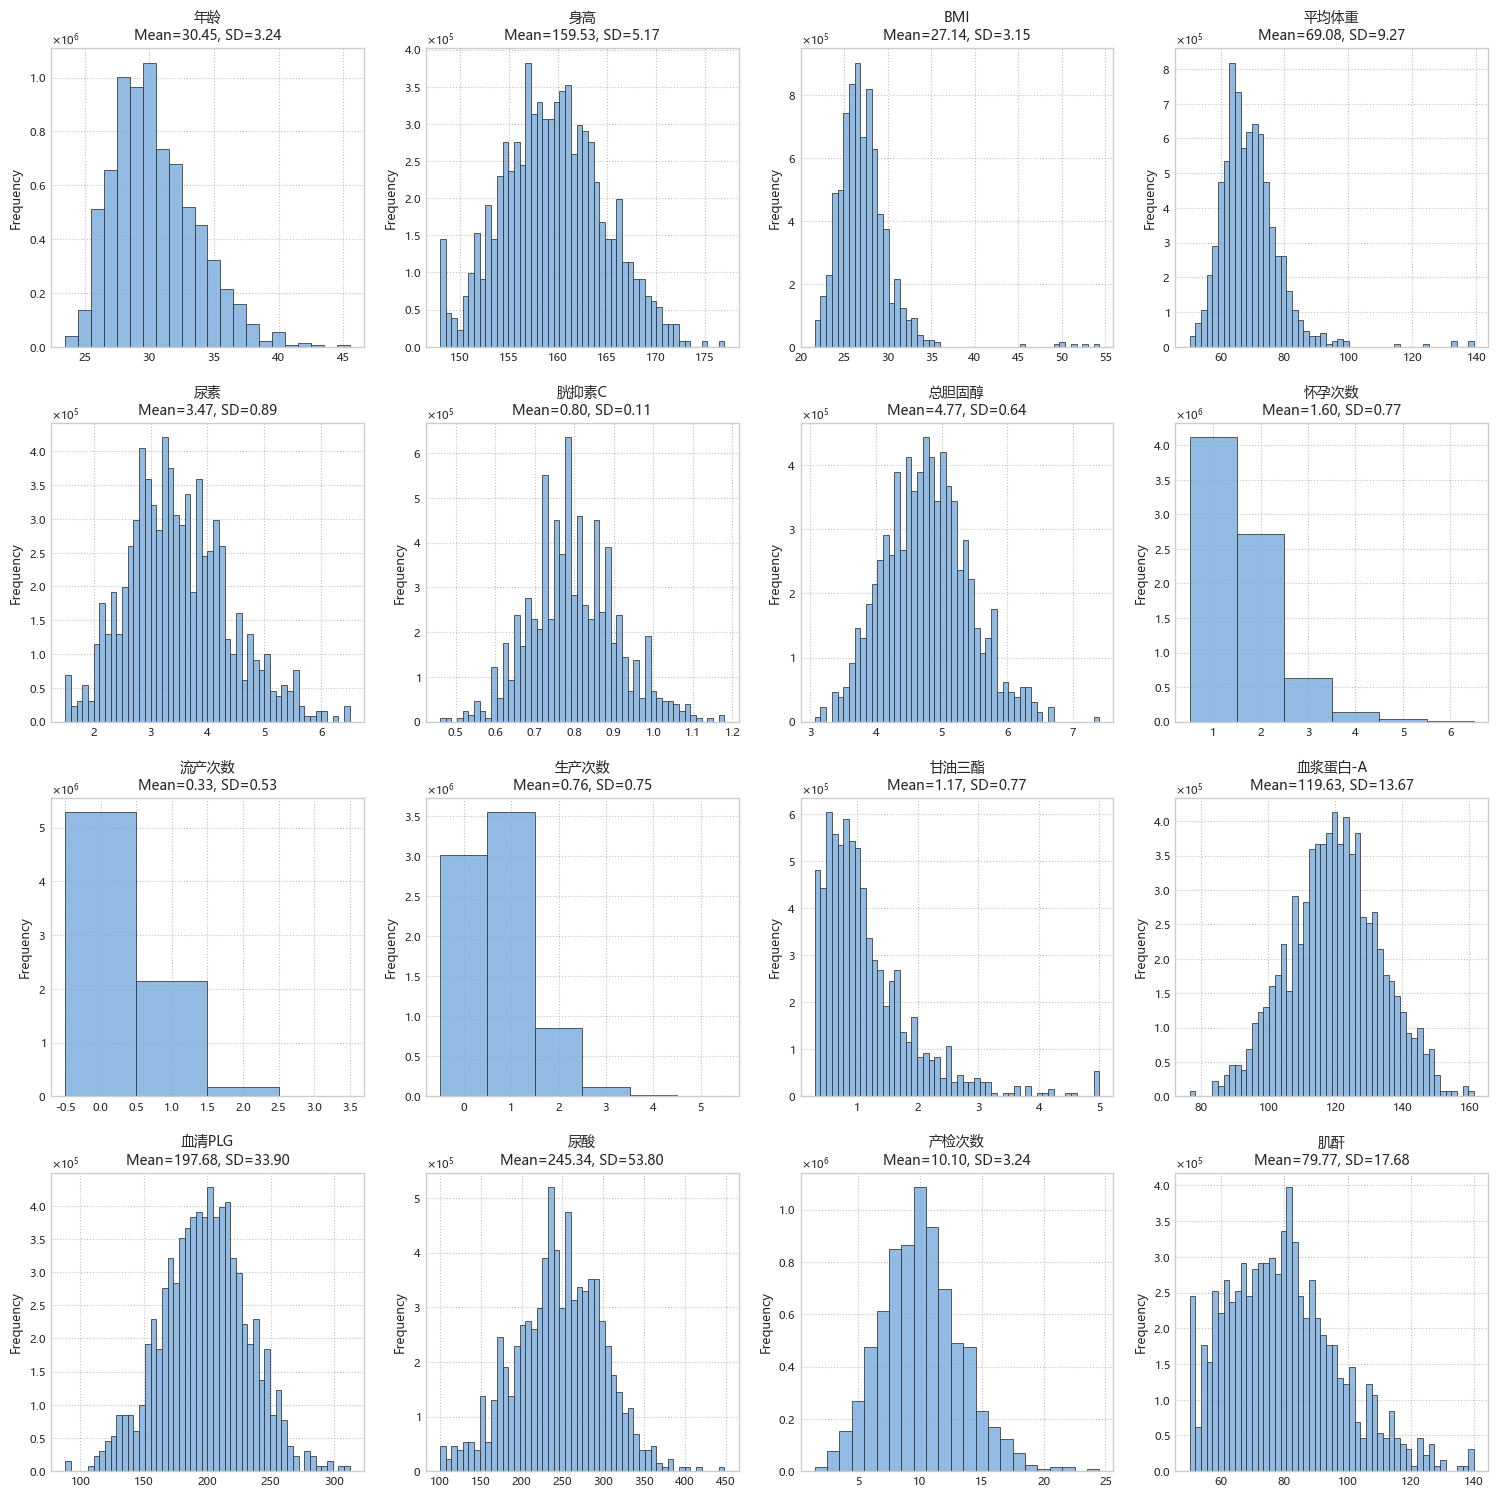

In [5]:
# 筛选菲尔元数据并打印分布
non_binary_features = df.copy()

# 遍历所有列，检查是否为二元数据
for col in df.columns:
    unique_vals = df[col].dropna().unique()
    if len(unique_vals) == 2:  # 如果只有两种唯一值，则认为是二元数据
        non_binary_features.drop(columns=[col], inplace=True)
        
# 为打印效率，将数据采样并打印分布
plot_distributions(data=df.iloc[:5000].copy(), plots_per_figure= 16)

In [ ]:
# 数据预处理
# 删除无关列（删除BMI，孕前肾炎，孕前蛋白尿）
df.drop(['BMI', '孕前肾炎', '孕前蛋白尿'], axis=1, inplace=True)
# 使用平均值填补缺失值
df.fillna(df.mean(), inplace=True)
df.shape

In [ ]:
# ===== t检验分析 =====
print("【t检验分析】")
features = df.columns[:-1]
for col in features:
    t_stat, p_val = ttest_ind_(df[df['妊娠期高血压'] == 1][col], df[df['妊娠期高血压'] == 0][col], equal_var=False, col_name=col)
    print(f"{col}：t={t_stat:.3f}, p={p_val:.5f}")

In [ ]:
# 划分数据集
X = df.drop(columns="妊娠期高血压")
y = df["妊娠期高血压"]
# 数据标准化
X_scaled = pd.DataFrame(MinMaxScaler().fit_transform(X), columns=X.columns)
print(X_scaled.iloc[:10, :5])

In [ ]:
# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)
# 训练集和验证集的分布
print("训练集分布：")
print(y_train.value_counts())
print("验证集分布：")
print(y_test.value_counts())

In [ ]:
# 使用smote方法扩展训练集数据
X_train_smote, y_train_smote = SMOTE().fit_resample(X_train, y_train)
# 训练集和验证集的分布
print("训练集分布：")
print(y_train_smote.value_counts())

In [ ]:
# ===== 遗传算法优化函数定义 =====
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

def create_individual():
    return [random.randint(50, 200), random.randint(3, 15), random.randint(2, 10)]

def evaluate_rf_orig(ind):
    model = RandomForestClassifier(n_estimators=int(ind[0]), max_depth=int(ind[1]), min_samples_split=int(ind[2]), random_state=42)
    model.fit(X_train, y_train)
    return (roc_auc_score(y_test, model.predict(X_test)),)

def evaluate_rf_smote(ind):
    model = RandomForestClassifier(n_estimators=int(ind[0]), max_depth=int(ind[1]), min_samples_split=int(ind[2]), random_state=42)
    model.fit(X_train_smote, y_train_smote)
    return (roc_auc_score(y_test, model.predict(X_test)),)

toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutPolynomialBounded, low=[50, 3, 2], up=[200, 15, 10], eta=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

In [ ]:
# ===== 遗传算法优化原始RF参数 =====
toolbox.register("evaluate", evaluate_rf_orig)
pop1 = toolbox.population(n=10)
algorithms.eaSimple(pop1, toolbox, cxpb=0.6, mutpb=0.3, ngen=10, verbose=False)
best_orig = tools.selBest(pop1, 1)[0]

# ===== 遗传算法优化SMOTE+RF参数 =====
toolbox.unregister("evaluate")
toolbox.register("evaluate", evaluate_rf_smote)
pop2 = toolbox.population(n=10)
algorithms.eaSimple(pop2, toolbox, cxpb=0.6, mutpb=0.3, ngen=10, verbose=False)
best_smote = tools.selBest(pop2, 1)[0]

In [ ]:
# ===== 构建随机森林模型 =====
# 原始模型rf_orig
rf_orig = RandomForestClassifier(n_estimators=int(best_orig[0]), max_depth=int(best_orig[1]), min_samples_split=int(best_orig[2]), random_state=42);best_orig=best_orig_2
rf_orig.fit(X_train, y_train)
y_pred_orig = rf_orig.predict(X_test)
y_prob_orig = rf_orig.predict_proba(X_test)[:, 1]

# 优化模型rf_smote
rf_smote = RandomForestClassifier(n_estimators=int(best_smote[0]), max_depth=int(best_smote[1]), min_samples_split=int(best_smote[2]), random_state=42);best_smote=best_smote_2
rf_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = rf_smote.predict(X_test)
y_prob_smote = rf_smote.predict_proba(X_test)[:, 1]

# 逻辑回归模型
logit = LogisticRegression(max_iter=200)
logit.fit(X_train, y_train)
y_pred_logit = logit.predict(X_test)
y_prob_logit = logit.predict_proba(X_test)[:, 1]

# 打印最优化参数
# 输出格式：最大树数量，最大特征，最大树深
print("原始RF模型参数：", best_orig)
print("SMOTE+RF模型参数：", best_smote)
print("Logistic回归模型参数：", logit.get_params())

In [ ]:
# ===== 模型评估 =====
def print_metrics(name, y_true, y_pred, y_prob):
    print(f"\n模型：{name}")
    print("准确率：", round(accuracy_score(y_true, y_pred), 4))
    print("查准率：", round(precision_score(y_true, y_pred), 4))
    print("查全率：", round(recall_score(y_true, y_pred), 4))
    print("AUC值：", round(roc_auc_score(y_true, y_prob), 4))

print_metrics("逻辑回归", y_test, y_pred_logit, y_prob_logit)
print_metrics("未使用SMOTE的随机森林", y_test, y_pred_orig, y_prob_orig)
print_metrics("使用SMOTE的随机森林", y_test, y_pred_smote, y_prob_smote)

In [ ]:
# ===== 十折交叉验证 AUC =====
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
print("\n【十折交叉验证 AUC】")
print("逻辑回归：", round(cross_val_score(logit, X_scaled, y, cv=cv, scoring='roc_auc').mean(), 4))
print("未使用SMOTE的随机森林：", round(cross_val_score(rf_orig, X_scaled, y, cv=cv, scoring='roc_auc').mean(), 4))
print("使用SMOTE的随机森林：", round(cross_val_score(rf_smote, X_scaled, y, cv=cv, scoring='roc_auc').mean(), 4))


In [ ]:
# ===== ROC曲线绘制 =====
plt.figure(figsize=(8, 6))
for label, y_prob, color in zip(
    ["逻辑回归", "原始随机森林", "SMOTE+随机森林"],
    [y_prob_logit, y_prob_orig, y_prob_smote],
    ['blue', 'green', 'darkorange']
):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{label} (AUC={roc_auc_score(y_test, y_prob):.4f})", color=color)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("假阳性率")
plt.ylabel("真正率")
plt.title("各模型ROC曲线对比")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# ===== 特征重要性分析 =====
importances = pd.Series(rf_smote.feature_importances_, index=X.columns).sort_values(ascending=False)
importances
